In [5]:
# Imports
import torch
import torch.nn.functional as F  # Parameterless functions, like (some) activation functions
import torchvision.datasets as datasets  # Standard datasets
import torchvision.transforms as transforms  # Transformations we can perform on our dataset for augmentation
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset  # Gives easier dataset managment by creating mini batches etc.
from sklearn.model_selection import train_test_split

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, f1_score, recall_score, precision_score, accuracy_score, confusion_matrix
from ViT_model import VisionTransformer

import sys


import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import time
import copy

In [6]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.has_mps:
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print("Device: {}".format(device))

Device: mps


In [7]:


directory = '/Users/elijahnelson/Desktop/SIWES/IML/Tactile_IML/train2dof'

def read_file(detect_or_pred, n = None):

    #store all directories in a list
    list_xela_allfiles = []
    list_sliplabel_allfiles = []

    for root, subdirectories, files in os.walk(directory):
        for sdirectory in subdirectories:

            #subdirectory with absolute path
            subdirectory = '{}/{}'.format(root, sdirectory)

            #read specific files in the subdirectory
            for file in os.listdir(subdirectory):
            
                if not file.startswith(".") and file.endswith("sensor1.csv"):
                    df = pd.read_csv(f'{subdirectory}/{file}', index_col=None, header=0)
                    
                    if detect_or_pred ==0:
                        list_xela_allfiles.append(df)
                    elif detect_or_pred ==1 and n is not None:
                        list_xela_allfiles.append(df[:-n])

                if not file.startswith(".") and file.endswith("label.csv"):
                    df = pd.read_csv('{}/{}'.format(subdirectory, file), index_col=None, header=0)
                    if detect_or_pred ==0:
                        list_sliplabel_allfiles.append(df)
                    elif detect_or_pred ==1 and n is not None: 
                        list_sliplabel_allfiles.append(df[n:])

    return list_xela_allfiles, list_sliplabel_allfiles

    #np.newaxis; np.zeros (3,4,4) -> 
                    


In [8]:
#concat the list of xela_allfiles and sliplabel_allfiles across axis = 0
n = 5
# list_xela_allfiles, list_sliplabel_allfiles = read_file(0)

#for slip prediction, comment the line above and uncomment the line below
list_xela_allfiles, list_sliplabel_allfiles = read_file(1, n)

pd_xela_allfiles = pd.concat(list_xela_allfiles, axis=0, ignore_index=True)
pd_sliplabel_allfiles = pd.concat(list_sliplabel_allfiles, axis=0, ignore_index=True)
pd_sliplabel_allfiles = pd_sliplabel_allfiles['slip']

#reshape the target array into (rows, 1)
tac_label = pd_sliplabel_allfiles.values.reshape(pd_sliplabel_allfiles.shape[0], 1)


In [9]:
# pd_sliplabel_allfiles.to_csv('labels.csv')
pd_xela_allfiles.columns

Index(['txl1_x', 'txl1_y', 'txl1_z', 'txl2_x', 'txl2_y', 'txl2_z', 'txl3_x',
       'txl3_y', 'txl3_z', 'txl4_x', 'txl4_y', 'txl4_z', 'txl5_x', 'txl5_y',
       'txl5_z', 'txl6_x', 'txl6_y', 'txl6_z', 'txl7_x', 'txl7_y', 'txl7_z',
       'txl8_x', 'txl8_y', 'txl8_z', 'txl9_x', 'txl9_y', 'txl9_z', 'txl10_x',
       'txl10_y', 'txl10_z', 'txl11_x', 'txl11_y', 'txl11_z', 'txl12_x',
       'txl12_y', 'txl12_z', 'txl13_x', 'txl13_y', 'txl13_z', 'txl14_x',
       'txl14_y', 'txl14_z', 'txl15_x', 'txl15_y', 'txl15_z', 'txl16_x',
       'txl16_y', 'txl16_z'],
      dtype='object')

# RE-ARRANGEMENT OF TABULAR DATA INTO IMAGES

In [10]:
#arrange the data by 3, 4, 4

#arrange the columns by x, y, z
col_x = []
col_y = []
col_z = []

pd_columns = pd_xela_allfiles.columns
for col in pd_columns:
    if col.endswith('x'):
        col_x.append(col)
    
    elif col.endswith('y'):
        col_y.append(col)
    
    elif col.endswith('z'):
        col_z.append(col)

#arrange the table using the arranged columns
pd_xela_allfiles_x = pd_xela_allfiles[col_x]
pd_xela_allfiles_y = pd_xela_allfiles[col_y]
pd_xela_allfiles_z = pd_xela_allfiles[col_z]


#scale the data in the arranged columns
#scale the data of the features

sc = MinMaxScaler() #standard scaler
sc.fit(pd_xela_allfiles_x)
pd_xela_allfiles_x = sc.transform(pd_xela_allfiles_x)

sc.fit(pd_xela_allfiles_y)
pd_xela_allfiles_y = sc.transform(pd_xela_allfiles_y)

sc.fit(pd_xela_allfiles_z)
pd_xela_allfiles_z = sc.transform(pd_xela_allfiles_z)



#reshape the arranged data per row to (4,4) AND rotate 90 degree anti-clockwise and append to a list
pd_x = []
pd_y = []
pd_z = []

for row in range(len(pd_xela_allfiles_x)):
    pd_x.append(np.rot90(pd_xela_allfiles_x[row].reshape(4,4)))
    pd_y.append(np.rot90(pd_xela_allfiles_y[row].reshape(4,4)))
    pd_z.append(np.rot90(pd_xela_allfiles_z[row].reshape(4,4)))

#add all the x, y, z in a single list
pd_main = [pd_x, pd_y, pd_z]

#arrange pd_main in a 3, 4, 4 array where its 3(4, 4) of x, y, z values
pd_image = np.zeros( (pd_xela_allfiles.shape[0], 3, 4, 4))

#per row, get (4,4) of x, y, z and assign it to pd_image to form the image
for row in range(pd_xela_allfiles.shape[0]):
    x_4_4 = pd_main[0][row]
    y_4_4 = pd_main[1][row]
    z_4_4 = pd_main[2][row]

    pd_image[row][0] = x_4_4
    pd_image[row][1] = y_4_4
    pd_image[row][2] = z_4_4


In [11]:
pd_label = pd_sliplabel_allfiles.values.reshape(pd_sliplabel_allfiles.shape[0], 1)

(226016, 3, 4, 4)


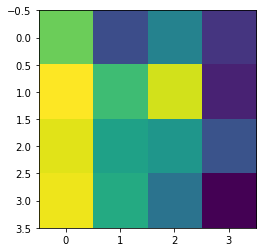

In [12]:
print(pd_image.shape)
plt.imshow(pd_image[0][1])
plt.show()

In [13]:
pd_image = torch.from_numpy(pd_image.astype(np.float32))
pd_label = torch.from_numpy(pd_label.astype(np.float32))

In [14]:
pd_image_train, pd_image_test, pd_label_train, pd_label_test = train_test_split(pd_image, pd_label, test_size=0.1, shuffle=True)

#split into train and validation
pd_image_train, pd_image_valid, pd_label_train, pd_label_valid = train_test_split(pd_image_train, pd_label_train, test_size=0.3, shuffle = True)

In [15]:
pd_image_train.shape, pd_label_train.shape

(torch.Size([142389, 3, 4, 4]), torch.Size([142389, 1]))

In [16]:
class seq_dataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return self.X.__len__()
    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [17]:
train_dataset = seq_dataset(pd_image_train, pd_label_train)
valid_dataset = seq_dataset(pd_image_valid, pd_label_valid)

train_loader = DataLoader(train_dataset, batch_size=4096, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=4096, shuffle=True, drop_last=True)

In [18]:
for i in train_loader:
    x_try = i[0]
    print(i[0].shape, i[1].shape)
    break

torch.Size([4096, 3, 4, 4]) torch.Size([4096, 1])


In [19]:
model = VisionTransformer(image_size=4, patch_size=1, in_chans=3, n_classes=1,
                  embed_dim=32, depth=2, n_heads=2, mlp_ratio=1., 
                  qkv_bias=True, p=0.1, attn_p=0.1, proj_p=0.1).to(device)

In [20]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([2.0]).to(device))
num_epochs = 300

In [21]:
#Training and validation loop 
train_loss = []
valid_loss = []

train_accuracy = []
valid_accuracy = []

t_loss = []
v_loss = []

t_acc = []
v_acc = []

for epoch in range(num_epochs):
    #Train per batch
    train_loss = []
    valid_loss = []
    train_accuracy = []
    valid_accuracy = []

    model.train()
    for (x, y) in (train_loader):
        #Forward pass
        y_pred = model(x.to(device))
        #compute the loss
        l = criterion(y_pred.to(device), y.to(device))
        #empty the gradients
        optimizer.zero_grad()
        #compute the gradient
        l.backward()
        #update the weights
        optimizer.step()
        #append each loss per batch
        train_loss.append(l.item())
        train_accuracy.append(accuracy_score(y.detach().cpu().numpy().round(), y_pred.detach().cpu().numpy().round()))
        
    

    #calculate and plot the validation loss
    model.eval()
    with torch.no_grad():
        for (x,y) in (valid_loader):
            y_pred = model(x.to(device))
            lv = criterion(y_pred.to(device), y.to(device))
            #append the loss per batch
            valid_loss.append(lv.item())
            #accuracy
            valid_accuracy.append(accuracy_score(y.detach().cpu().numpy().round(), y_pred.detach().cpu().numpy().round()))

    #append the total loss and accuracy per epoch
    t_loss.append(np.mean(train_loss))
    v_loss.append(np.mean(valid_loss))
    t_acc.append(np.mean(train_accuracy))
    v_acc.append(np.mean(valid_accuracy))

    print(f'Epoch {epoch+1}, loss = {np.mean(train_loss):.4f} , val_loss = {np.mean(valid_loss):.4f}')
    torch.save(model.state_dict(), 'ViT_checkpoint.pth')

Epoch 1, loss = 0.5820 , val_loss = 0.4473
Epoch 2, loss = 0.4468 , val_loss = 0.4331


KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), f'ViT_n{n}.pth')

In [ ]:
def plot(metric, title):
    plt.plot(metric)
    plt.title(title)
    plt.show() 

In [ ]:
plot(t_loss, "Train Loss")
plot(v_loss, "Val Loss")

plot(t_acc, "Train Accuracy")
plot(v_acc, "Val Accuracy")